In [ ]:
# 1. Install Dependencies and Setup

In [ ]:
pip install tensorflow-gpu==2.10.0

In [ ]:
!pip list

In [40]:
import tensorflow as tf
import os

In [41]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [42]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [43]:
import cv2 
import imghdr

In [44]:
data_dir = 'data' 

In [45]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [46]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [47]:
import numpy as np 
from matplotlib import pyplot as plt

In [48]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [49]:
data_iterator = data.as_numpy_iterator()

In [50]:
batch = data_iterator.next()

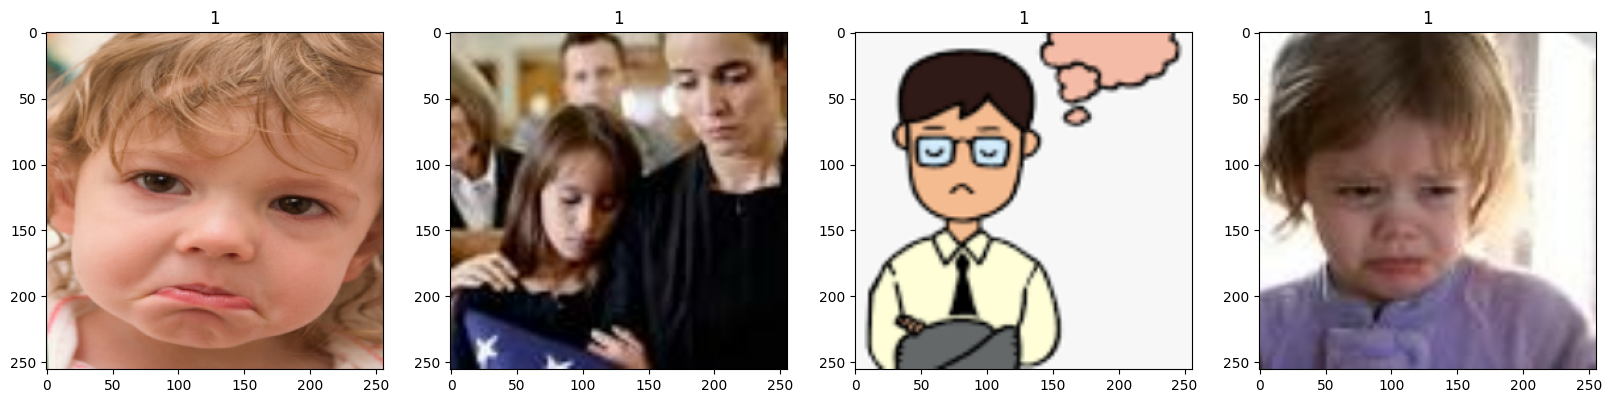

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [52]:
data = data.map(lambda x,y: (x/255, y))

In [53]:
data.as_numpy_iterator().next()

(array([[[[0.14901961, 0.14901961, 0.14901961],
          [0.14800858, 0.14800858, 0.14800858],
          [0.14341299, 0.14341299, 0.14341299],
          ...,
          [0.50811887, 0.50811887, 0.50811887],
          [0.51271445, 0.51271445, 0.51271445],
          [0.5137255 , 0.5137255 , 0.5137255 ]],
 
         [[0.14935662, 0.14935662, 0.14935662],
          [0.14834559, 0.14834559, 0.14834559],
          [0.14375   , 0.14375   , 0.14375   ],
          ...,
          [0.5089377 , 0.5089377 , 0.5089377 ],
          [0.51313835, 0.51313835, 0.51313835],
          [0.5140625 , 0.5140625 , 0.5140625 ]],
 
         [[0.15088849, 0.15088849, 0.15088849],
          [0.14987744, 0.14987744, 0.14987744],
          [0.14528187, 0.14528187, 0.14528187],
          ...,
          [0.51265967, 0.51265967, 0.51265967],
          [0.51506513, 0.51506513, 0.51506513],
          [0.51559436, 0.51559436, 0.51559436]],
 
         ...,
 
         [[0.46629903, 0.46629903, 0.46629903],
          [0.46013

# 5. Split Data

In [54]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [55]:
train_size

7

In [56]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [57]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [59]:
model = Sequential()

In [60]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [61]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [63]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 8s 847ms/step - loss: 0.7016 - accuracy: 0.5536 - val_loss: 0.5783 - val_accuracy: 0.5625
Epoch 2/20
7/7 [==============================] - 7s 845ms/step - loss: 0.6017 - accuracy: 0.6607 - val_loss: 0.6036 - val_accuracy: 0.6562
Epoch 3/20
7/7 [==============================] - 7s 854ms/step - loss: 0.5511 - accuracy: 0.7188 - val_loss: 0.4191 - val_accuracy: 0.8438
Epoch 4/20
7/7 [==============================] - 7s 828ms/step - loss: 0.4108 - accuracy: 0.8661 - val_loss: 0.3563 - val_accuracy: 0.8281
Epoch 5/20
7/7 [==============================] - 7s 864ms/step - loss: 0.3317 - accuracy: 0.8661 - val_loss: 0.5579 - val_accuracy: 0.7812
Epoch 6/20
7/7 [==============================] - 7s 822ms/step - loss: 0.5006 - accuracy: 0.7768 - val_loss: 0.2868 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - 7s 855ms/step - loss: 0.2902 - accuracy: 0.9196 - val_loss: 0.1226 - val_accuracy: 1.0000
Epoch 8/20
7/7 [====

# 8. Plot Performance

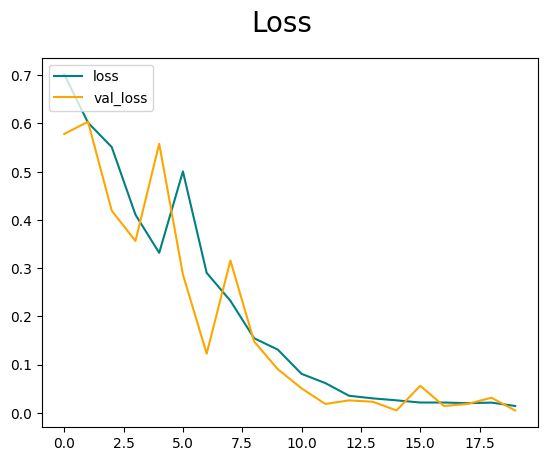

In [77]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

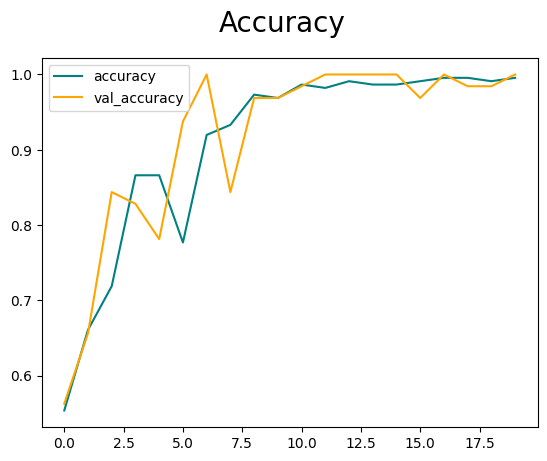

In [78]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [79]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [80]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [81]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 85ms/step


In [82]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [83]:
import cv2

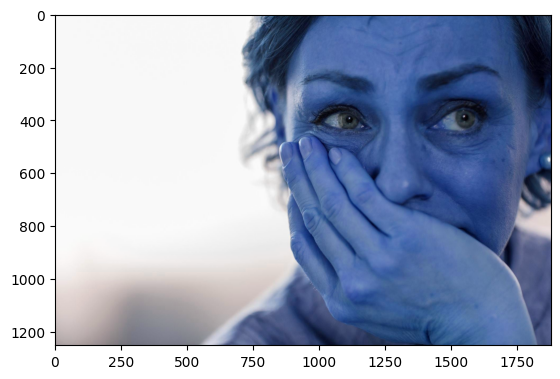

In [84]:
img = cv2.imread('0x0.jpg')
plt.imshow(img)
plt.show()

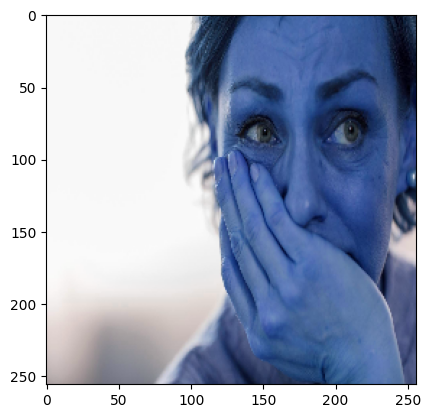

In [85]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [86]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 24ms/step


In [87]:
yhat

array([[0.95113844]], dtype=float32)

In [88]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)